In [1]:
import pandas as pd
import time 
import json
import urllib.request
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from pandas.io.json import json_normalize
from joblib import Parallel, delayed
import statsmodels.api as sm
from scipy import stats

## Importing RPi JSON Data to DataFrame

In [2]:
df = pd.read_json("https://alte-rs.ddnss.de/weather/processed/history.json")
df['time'] = pd.to_datetime(df['time'])
df['temp'] = pd.to_numeric(df['temp'])
df['pressure'] = pd.to_numeric(df['pressure'])
df['humidity'] = pd.to_numeric(df['humidity'])
dataframe_rpi = df.set_index('time')
print(dataframe_rpi.shape)
dataframe_rpi.head()

(35186, 3)


,humidity,pressure,temp
time,,,
2018-06-22 16:20:01.656,36.116451,1025.179932,28.907051
2018-06-22 16:20:40.606,35.238693,1025.148682,28.870728
2018-06-22 16:21:19.756,35.684219,1025.106445,28.852566
2018-06-22 16:21:58.636,35.843815,1025.139404,28.907051
2018-06-22 16:22:37.505,36.053280,1025.058105,28.870728


## Smoothing RPi Data

### Rolling Sums

(35186, 3)
humidity    3
pressure    3
temp        3
dtype: int64
                          humidity     pressure       temp
time                                                      
2018-06-22 16:20:01.656        NaN          NaN        NaN
2018-06-22 16:20:40.606  35.677572  1025.164307  28.888889
2018-06-22 16:21:19.756  35.679788  1025.145020  28.876781
2018-06-22 16:21:58.636  35.720795  1025.143616  28.884349
2018-06-22 16:22:37.505  35.787292  1025.126514  28.881625


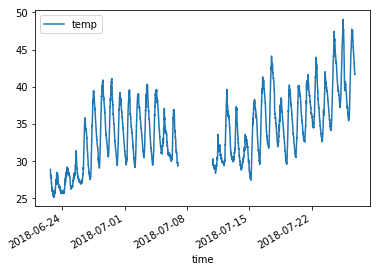

In [3]:
window_length='10min'
min_data_points=2
dataframe_rpi_rolling = dataframe_rpi.rolling(window=window_length,min_periods=min_data_points).mean()


print(dataframe_rpi_rolling.shape)
print(dataframe_rpi_rolling.isnull().sum())
print(dataframe_rpi_rolling.head())
dataframe_rpi_rolling.plot(y='temp')

### Resampling

(24584, 3)
humidity    0
pressure    0
temp        0
dtype: int64
                      humidity     pressure       temp
time                                                  
2018-06-22 16:20:00  36.116451  1025.179932  28.907051
2018-06-22 16:22:00  36.053280  1025.058105  28.870728
2018-06-22 16:24:00  35.697521  1025.116943  28.943377
2018-06-22 16:26:00  35.335114  1025.070068  28.943377
2018-06-22 16:28:00  36.714924  1025.146240  28.798077


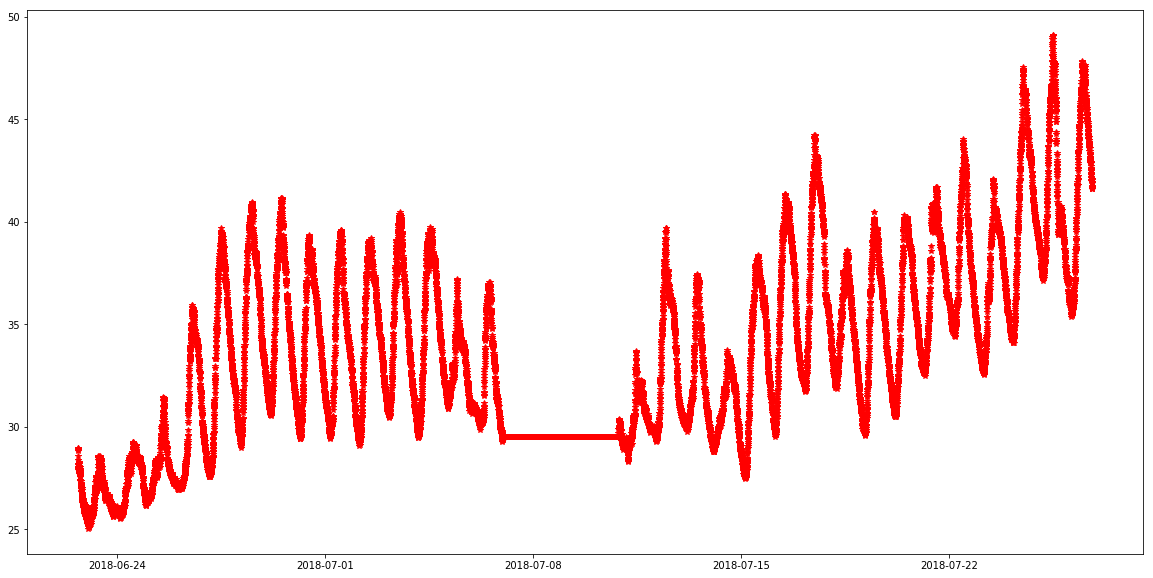

In [4]:
dataframe_rpi_resampled = dataframe_rpi.resample('2min').bfill()

print(dataframe_rpi_resampled.shape)
print(dataframe_rpi_resampled.isnull().sum())
print(dataframe_rpi_resampled.head())
plt.figure(figsize=(20,10))
plt.plot(dataframe_rpi_resampled['temp'],'r*')

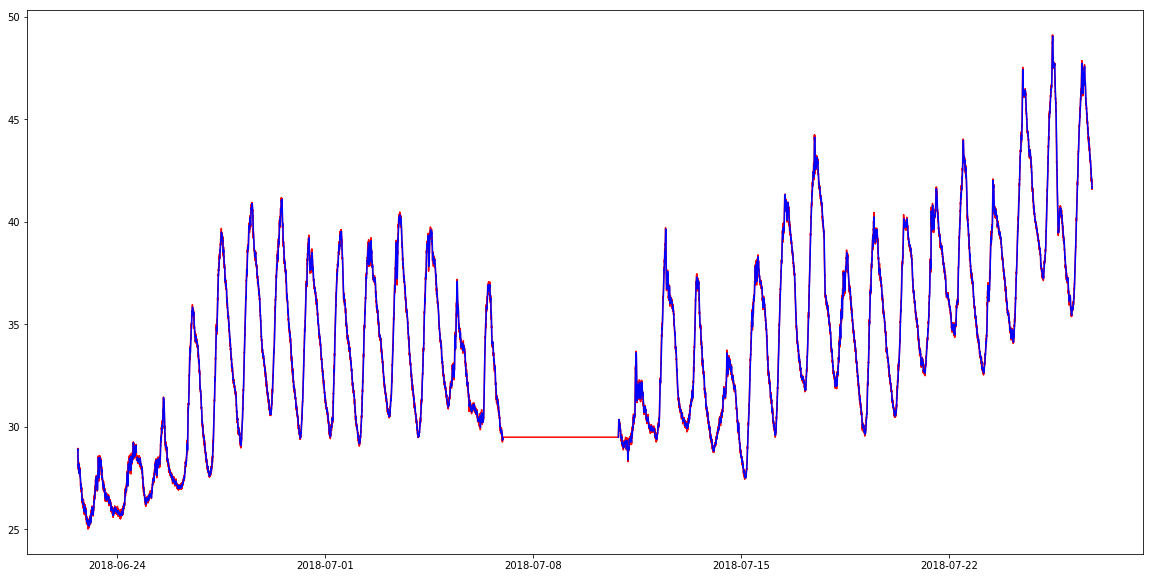

In [5]:
plt.figure(figsize=(20,10))
plt.plot(dataframe_rpi_resampled['temp'],'r-',dataframe_rpi_rolling['temp'],'b-')

## Importing OWM Data

In [6]:
with urllib.request.urlopen("https://alte-rs.ddnss.de/weather/processed/history_owm.json") as url:
    data = json.loads(url.read().decode())
init_table = json_normalize(data)
weather_descr = json_normalize(data,record_path=['weather'],record_prefix='weather.')
temp = init_table.join(weather_descr)
temp['time'] = pd.to_datetime(temp['dt'],unit='s')
temp['temp'] = pd.to_numeric(temp['main.temp'])-273.15
temp['humidity'] = pd.to_numeric(temp['main.humidity'])
temp['pressure'] = pd.to_numeric(temp['main.pressure'])
dataframe_owm = temp.set_index('time')
dataframe_owm_resampled = dataframe_owm[['temp','pressure','humidity']].resample('30min').mean()
dataframe_owm_resampled.head()

,temp,pressure,humidity
time,,,
2018-06-16 20:30:00,17.509474,1013.0,77.0
2018-06-16 21:00:00,18.010000,1013.0,77.0
2018-06-16 21:30:00,18.010000,1013.0,77.0
2018-06-16 22:00:00,17.506667,1013.0,77.0
2018-06-16 22:30:00,17.000000,1013.0,82.0


## Creating Feature Matrix and Prediction Vector

### Reducing the input values to a maxmimum of one row every 5min

In [7]:
time_step = timedelta(minutes = 5)
init = dataframe_rpi_rolling.index[0]

for time in dataframe_rpi_rolling.index:
    if time-init > time_step:
        init = time
    else:
        dataframe_rpi_rolling = dataframe_rpi_rolling.drop(time)
dataframe_rpi_rolling.head()

,humidity,pressure,temp
time,,,
2018-06-22 16:25:30.796,35.743404,1025.125806,28.879808
2018-06-22 16:30:44.135,36.051825,1025.124542,28.802618
2018-06-22 16:36:02.356,37.181235,1025.162430,28.506343
2018-06-22 16:41:20.815,38.239161,1025.227509,28.176015
2018-06-22 16:46:39.475,38.701938,1025.252014,28.105636


### Creating prediction matrix y 

In [8]:
# dataframe_input=dataframe_rpi_resampled
dataframe_input = dataframe_rpi_rolling

prediction_steps = 10
history_steps = 10

y = dataframe_input[ prediction_steps + history_steps :]
y_index = dataframe_input[ prediction_steps + history_steps :].index

length = len(y)
print(y.shape)
print(np.isnan(y).sum())

(7882, 3)
humidity    2
pressure    2
temp        2
dtype: int64


### Creating input matrix x, which contains 20 consequtive historical values (time steps)

In [21]:
x = np.empty((length, 3*history_steps))


def xrow (start):
    return dataframe_input[ start : start + history_steps ].values.flatten();


for n in  range(0,length):
    x[n] =xrow(n)
print(x.shape)
print(np.isnan(x).sum())

(7882, 30)
60


## Using Imputer to get rid of NaNs


In [22]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(x)
x_imputer = imputer.transform(x)
imputer = imputer.fit(y)
y_imputer = pd.DataFrame(data=imputer.transform(y), columns=['humidity','pressure','temp'], index=y_index)

y_imputer.shape

(7882, 3)

## Splitting up into training and testing

In [47]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size = 1/3, random_state = 0)


cut=4*len(y_imputer)//5 # First 2/3 of data is for training, the other testing
y_train = y_imputer[0:cut]
x_train = x_imputer[0:cut]
y_test = y_imputer[cut:]
x_test = x_imputer[cut:]

## Scaling the features

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.fit_transform(x_test)


## Learning with linear regression

In [49]:
training_data_input  = x_train_sc
training_data_target = y_train['temp']

testing_data_input   = x_test_sc
testing_data_target  = y_test['temp']



from sklearn.linear_model import LinearRegression
regressor = LinearRegression(n_jobs=-1)
regressor = regressor.fit(training_data_input, training_data_target)
sorted_coefs = regressor.coef_.reshape(history_steps,3)
intercept = regressor.intercept_

training_result = pd.DataFrame(data=regressor.predict(training_data_input), index=y_train.index)
testing_result  = pd.DataFrame(data=regressor.predict(testing_data_input), index=y_test.index)

## Gathering Statistics

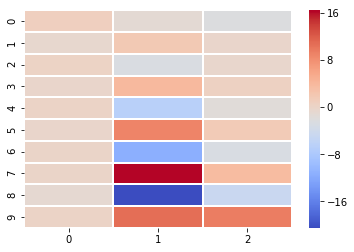

In [50]:
training_data_const = sm.add_constant(training_data_input)
insample_stats = sm.OLS(training_data_target, training_data_const).fit()
testing_data_const = sm.add_constant(testing_data_input)
outsample_stats = sm.OLS(testing_data_target, testing_data_const).fit()

sn.heatmap(sorted_coefs,cmap='coolwarm',linewidths=1)

#print(insample_stats.summary())
#print(outsample_stats.summary())


## In-Sample and Out-Of-Sample Plots

Text(0.5,1,'Out-of-Sample')

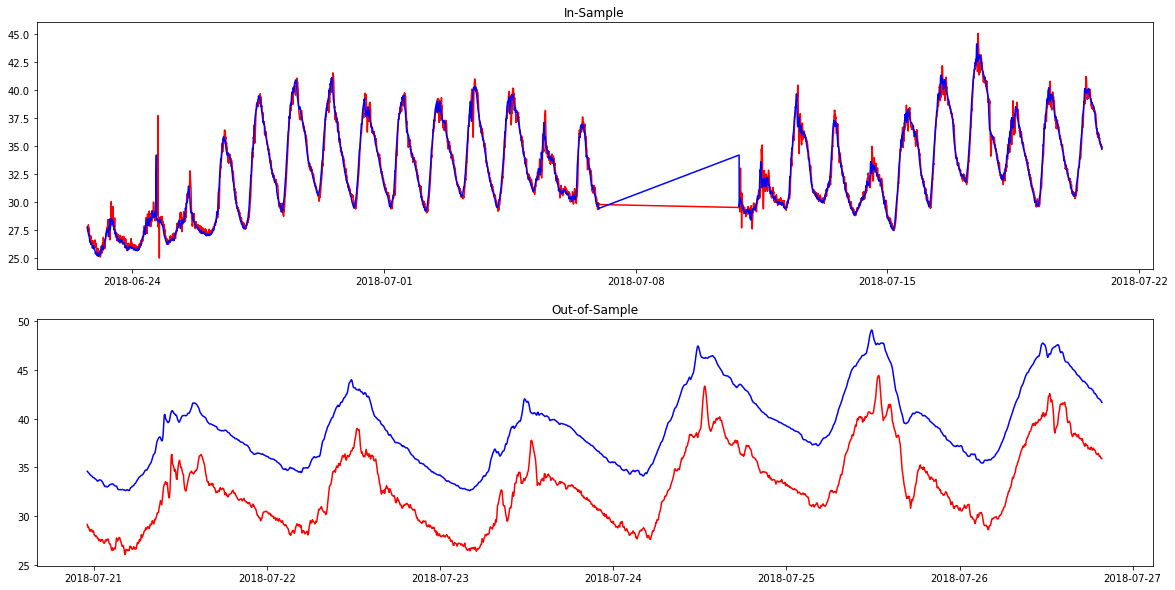

In [51]:
plt.figure(1,figsize=(20,10))
plt.title('In-Sample vs Out-of-Sample')
plt.subplot(211)
plt.plot(training_result,'r-',training_data_target,'b-')
plt.title('In-Sample')
plt.subplot(212)
plt.plot(testing_result,'r-',testing_data_target,'b-')
plt.title('Out-of-Sample')